In [1]:
!pip install fastai -Uqqq

In [2]:
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from fastai.vision.all import *

In [3]:
labels = loadmat('/kaggle/input/mall-crowd-estimation/mall_dataset/mall_gt.mat')['frame'][0]

In [4]:
label = labels[0] # extract GT for first frame
ground_truth = (label[0][0][0]) # GT array
ground_truth.shape

(29, 2)

In [5]:
ground_truth[:3]

array([[126.77986348,  60.70477816],
       [116.95051195,  47.59897611],
       [175.10750853,  44.3225256 ]])

In [7]:
def generate_label(labels, image_shape=(480,640)):
    "Generate an array based on objects positions"
    label = np.zeros(image_shape, dtype=np.float32)
    for x, y in labels:
        label[int(y)][int(x)] = 1
    return label

In [8]:
l = generate_label(ground_truth)
l.shape

(480, 640)

In [9]:
l.sum()

29.0

In [10]:
# Density Map Tensor
class TensorDMap(TensorImageBase): 
    _show_args = {'alpha':0.5, 'cmap':'hot'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, title=str(array(self).sum()),**{**self._show_args, **kwargs})
# TensorDMap._tensor_cls = TensorDMap

In [ ]:
# # Density Map type
# class DMap(PILBase): 
#     _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    
#     def show(self, ctx=None, **kwargs):
#         x = array(self).astype('float') # onvert to float for next step
#         x =  gaussian_filter(x, sigma=(1, 1), order=0) # create density map
#         ax = plt.imshow(x, **self._show_args);
#         return ax

# # DMap._tensor_cls = TensorDMap

In [12]:
def get_lbl(fn):
    indx = int(re.findall('.+/seq_(\d+).jpg', str(fn))[0])-1 # extract indx from fn
    lbl = labels[indx]
    return generate_label(lbl[0][0][0], (480,640))

In [ ]:
# Density Map type
class DMap(PILBase): 
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    @classmethod
    def create(cls, fn):
        if isinstance(fn,ndarray): 
            l = fn
        else:
            l = get_lbl(fn)
        l = gaussian_filter(l, sigma=(4, 4), order=0)
        return cls(Image.fromarray(l))
    def show(self, ctx=None, **kwargs):
        ax = plt.imshow(array(self), **self._show_args);
        return ax

# DMap._tensor_cls = TensorDMap

In [26]:
# Density Map type
class DMap(PILBase): 
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    @classmethod
    def create(cls, fn):
        if isinstance(fn,ndarray): 
            l = fn
        else:
            l = get_lbl(fn)
        l = gaussian_filter(l, sigma=(4, 4), order=0)
        return cls(Image.fromarray(l))
    def show(self, ctx=None, **kwargs):
        ax = show_image(array(self), title=str(array(self).sum()), ctx=ctx, **self._show_args);
        return ax

DMap._tensor_cls = TensorDMap

In [81]:
# Density Map type
class DMap(PILBase): 
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'hot'}
    @classmethod
    def create(cls, fn):
        if isinstance(fn,ndarray): 
            l = fn
        else:
            l = get_lbl(fn)
        l = gaussian_filter(l, sigma=(4, 4), order=0)
        return cls(Image.fromarray(l))
    def show(self, ctx=None, **kwargs):
        ax = show_image(self, title=str((array(self).sum())), ctx=ctx, **self._show_args);
        return ax

DMap._tensor_cls = TensorDMap

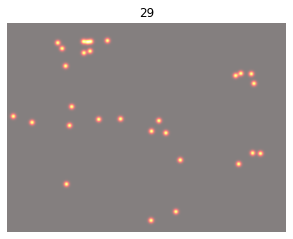

In [61]:
dm = DMap.create(l)
dm.show();

In [62]:
fn = '/kaggle/input/mall-crowd-estimation/mall_dataset/frames/seq_000001.jpg'

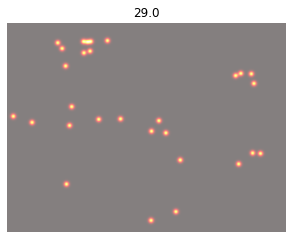

In [82]:
dm = DMap.create(fn)
dm.show();

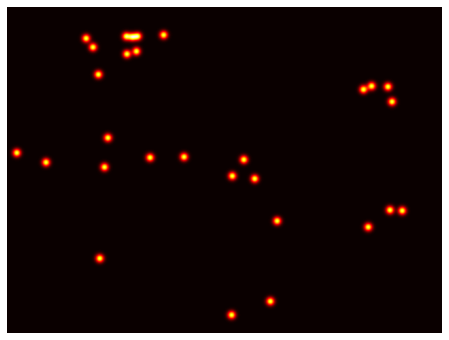

In [64]:
show_image(dm, figsize=(12,6), cmap="hot");

In [65]:
type(dm)

__main__.DMap

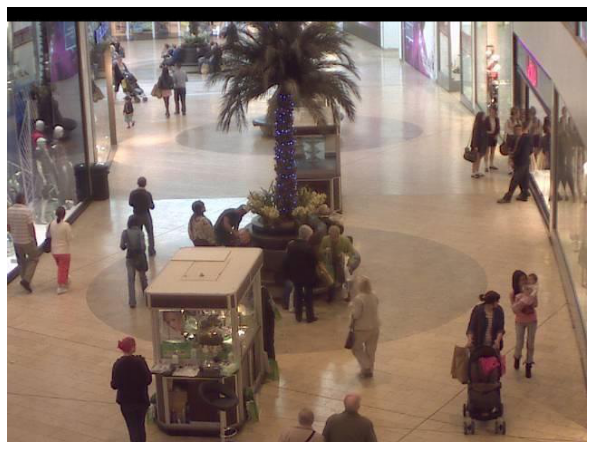

In [97]:
img = PILImage.create(fn)
show_image(img,figsize=(18,8));


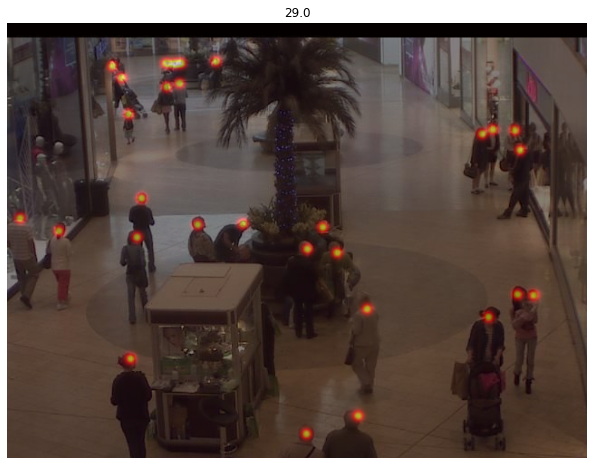

In [83]:
img = PILImage.create(fn)
ax = show_image(img,figsize=(18,8))
dm.show(ctx=ax);

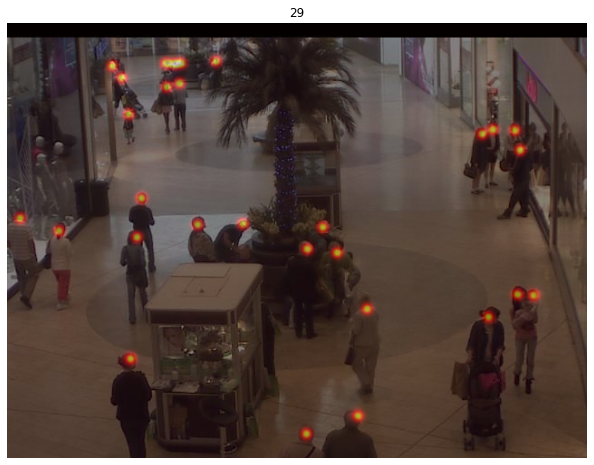

In [78]:
img = PILImage.create(fn)
ax = show_image(img,figsize=(18,8))
dm.show(ctx=ax);

In [84]:
tup = (img, dm)
rtup = RandomCrop(224)(tup)
x, y = rtup
x.shape, y.shape

((224, 224), (224, 224))

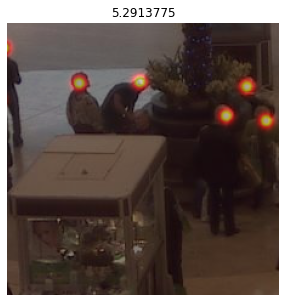

In [85]:
ax = x.show()
y.show(ctx=ax);

In [86]:
files = sorted(get_image_files('/kaggle/input/mall-crowd-estimation/mall_dataset/frames/'))
len(files)

2000

In [87]:
dset = Datasets(files, [[PILImage.create], [DMap.create]], splits=[list(range(800)), list(range(800,1000))])

In [88]:
dset[0]

(PILImage mode=RGB size=640x480, DMap mode=F size=640x480)

In [89]:
@ToTensor
def encodes(self, o:DMap): return o._tensor_cls(image2tensor(o))

In [90]:
dls = dset.dataloaders(bs=6, after_item=[RandomCrop(224), ToTensor], 
                      after_batch=[IntToFloatTensor, #Normalize.from_stats(*imagenet_stats)
                      ],
                      )

In [91]:
b = dls.one_batch()
b[0].shape, b[1].shape

((6, 3, 224, 224), (6, 1, 224, 224))

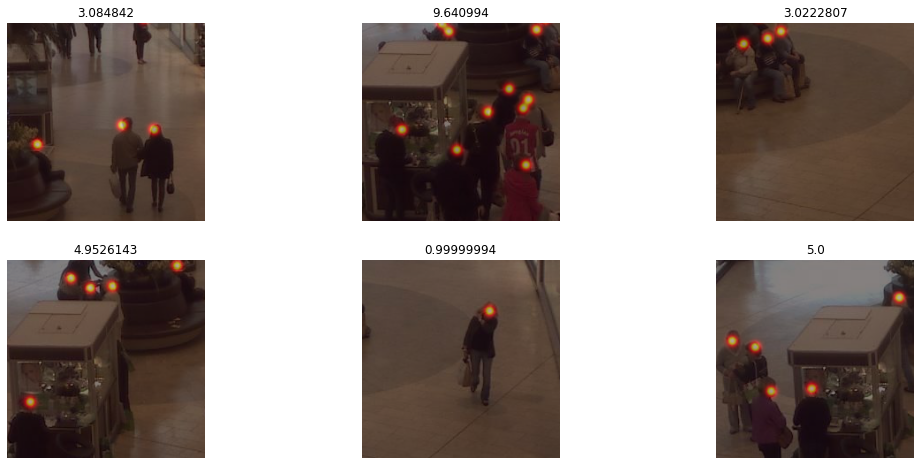

In [96]:
dls.show_batch(figsize=(18,8))

In [ ]:
i=1
img, targ = b[0][i], b[1][i]

In [ ]:
(b[0][i]).max()



In [ ]:
IntToFloatTensor()(ToTensor()(PILImage.create(fn))).max()

In [ ]:
show_image(img);

In [ ]:
(targ).sum()

In [28]:
dls = dset.dataloaders(bs=64, after_item=[RandomCrop(160), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      )

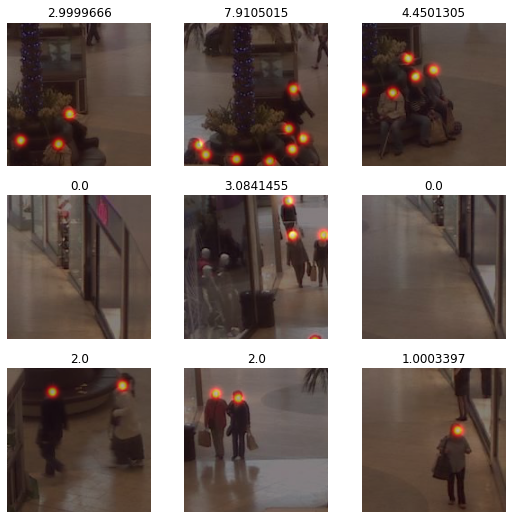

In [29]:
dls.show_batch()

In [32]:
m = resnet34(pretrained=True)
m = nn.Sequential(*list(m.children())[:-2])
unet = DynamicUnet(m, 1, (160, 160), blur=False, blur_final=False, self_attention=True, y_range=None, last_cross=True)

In [34]:
learn = Learner(dls, unet, loss_func=MSELossFlat(), metrics=mae)

In [37]:
learn.freeze()
learn.summary()

DynamicUnet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 80 x 80   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                     

In [ ]:
learn.fit(15, 1e-3)

In [ ]:
learn.unfreeze();
learn.fit_one_cycle(30, slice(1e-6,1e-4))

In [ ]:
learn.show_results(0)

In [ ]:
files[1000]

In [ ]:
PILImage.create(files[1500])

In [ ]:
img, mask = RandomCrop(160)((PILImage.create(files[1500]), DMap.create(files[1500])))
ax = img.show();
mask.show(ctx=ax);

In [ ]:
tdl = dls.test_dl([img])

In [ ]:
out, _ = learn.get_preds(dl=tdl)
out.shape

In [ ]:
out.sum()

In [ ]:
ax = img.show();
TensorDMap(out.squeeze()).show(ctx=ax);

In [ ]:
out = out.squeeze()

In [ ]:
out = torch.where(out>0, out, torch.zeros_like(out))

In [ ]:
ax = img.show();
TensorDMap(out.squeeze()).show(ctx=ax);

In [ ]:
dls.valid.show_batch()

In [ ]:
with dls.valid_ds.set_split_idx(0):
  dls.valid.show_batch()

In [ ]:
with dls.valid_ds.set_split_idx(0):
  learn.show_results(alpha=.35)

In [ ]:
learn.save("crowd-res34-160px")

In [ ]:
with dls.valid_ds.set_split_idx(0):
  preds = learn.get_preds()

In [ ]:
im, dn = preds[0][0], preds[0][1]

In [ ]:
RandomCrop(160)(dls.valid_ds[0][0]).show()

In [ ]:
show_image(im)

In [ ]:
show_image(dn)